In [1]:
import pandas as pd
from datetime import timedelta, date 
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler #standardization and normalization
scaler=StandardScaler()

from sklearn.metrics import r2_score
from sklearn.cluster import KMeans, k_means

#Load the data
df=pd.read_excel("KCA Loan data.xlsx")
print(df.shape,"\n")
df.head(5)

(149321, 8) 



,OutstandingLoan,terms,disbursedamount,installmentstartdate,Lastinstallmentdate,LastInstallmentAmount,disbursementdate,Gender
0,-18134.96,1,0.0,2022-02-18,2022-02-18,0.0,2022-01-19,M
1,-6769.98,1,0.0,2021-12-31,2021-12-31,0.0,2021-12-01,F
2,-10000.00,1,0.0,2021-12-30,2021-12-30,0.0,2021-11-30,F
3,-30000.00,1,0.0,2021-12-26,2021-12-26,0.0,2021-11-26,F
4,-1269.98,1,0.0,2021-12-26,2021-12-26,0.0,2021-11-26,M


In [2]:
#We format some the Gender Column to be more explanatory
df.loc[df.Gender=="M", "Gender"]=1
df.loc[df.Gender=="F", "Gender"]=0
df.loc[df.Gender=="U", "Gender"]=2
df.head()

,OutstandingLoan,terms,disbursedamount,installmentstartdate,Lastinstallmentdate,LastInstallmentAmount,disbursementdate,Gender
0,-18134.96,1,0.0,2022-02-18,2022-02-18,0.0,2022-01-19,1
1,-6769.98,1,0.0,2021-12-31,2021-12-31,0.0,2021-12-01,0
2,-10000.00,1,0.0,2021-12-30,2021-12-30,0.0,2021-11-30,0
3,-30000.00,1,0.0,2021-12-26,2021-12-26,0.0,2021-11-26,0
4,-1269.98,1,0.0,2021-12-26,2021-12-26,0.0,2021-11-26,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149321 entries, 0 to 149320
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   OutstandingLoan        149321 non-null  float64       
 1   terms                  149321 non-null  int64         
 2   disbursedamount        149321 non-null  float64       
 3   installmentstartdate   149285 non-null  datetime64[ns]
 4   Lastinstallmentdate    149320 non-null  datetime64[ns]
 5   LastInstallmentAmount  146885 non-null  float64       
 6   disbursementdate       149274 non-null  datetime64[ns]
 7   Gender                 149321 non-null  object        
dtypes: datetime64[ns](3), float64(3), int64(1), object(1)
memory usage: 9.1+ MB


#### From the above data information, we can see that the data types are ok and may not need anyr reworking

#### Handling missing values
Let us see the columns with missing values

In [4]:
df.isnull().sum()

OutstandingLoan             0
terms                       0
disbursedamount             0
installmentstartdate       36
Lastinstallmentdate         1
LastInstallmentAmount    2436
disbursementdate           47
Gender                      0
dtype: int64

#### installmentstartdate column has 36 missing values
   we will impute this by adding 30 days to the **disbursmentdate** assuming that one starts paying one month after disbursment

In [5]:
df["installmentstartdate"]=df.installmentstartdate.fillna(df.disbursementdate + timedelta(days=30))
#df=df.astype({'installmentstartdate': 'datetime64[ns]'})

#### disbursmentdate column has 47 missing values
   we will impute this by subtracting 30 days from  **installmentstartdate** assuming that one starts paying one month after disbursment

In [6]:
df["disbursementdate"]=df.disbursementdate.fillna(df.installmentstartdate - timedelta(days=30))

#### Lastinstallmentdate column has 1 missing values
   we will impute this  with **installmentstartdate**+30days since this was transaction was offered for 1 term only meaning one month

In [7]:
df["Lastinstallmentdate"]=df.Lastinstallmentdate.fillna(df.installmentstartdate+timedelta(days=30))

#### LastInstallmentAmount column has 2436 missing values
This is quite alot of missing values. We are not willing to drop all those rows of data. So we will fill all those missing values with values zero assuming that it means there was NILL payment

In [8]:
df["LastInstallmentAmount"]=df.LastInstallmentAmount.fillna(0)
df.isnull().sum()

OutstandingLoan          0
terms                    0
disbursedamount          0
installmentstartdate     0
Lastinstallmentdate      0
LastInstallmentAmount    0
disbursementdate         0
Gender                   0
dtype: int64

# Let us check the defaulters!


In [9]:
import datetime
from datetime import timedelta as dt

df["defaulter"]=""

#date today minus when the persons started paying the installments
df["terms_lapsed"]=(datetime.datetime.now()) #this can be misleading if data was not extracted recently
df["terms_lapsed"]=df["terms_lapsed"]-df.installmentstartdate

#extract days from timedelta
df["terms_lapsed"]=pd.to_timedelta(df["terms_lapsed"],errors="coerce").dt.days 

#divide the days by 30 days of the month to get approximate months that have lapsed
df["terms_lapsed"]=df.terms_lapsed/30 

#Get all those whose term has lapsed also includes..:
#Those whose term lapsed, they paid last installment, yet they still have balances
df.loc[((df.terms_lapsed)>(df.terms) | (((df.terms_lapsed)==(df.terms)) & (df.OutstandingLoan>0)  ) ,"defaulter")]= 1

#Get all those whose terms are not yet over
df.loc[(df.terms_lapsed)<(df.terms),"defaulter"]= 0 

#get all those whose terms havent lapsed but they did not pay last installment
df.loc[(df.terms_lapsed)<(df.terms) & (df.LastInstallmentAmount==0)  ,"defaulter"]= 2 #unknown

In [10]:
#Create a ratio of Disbursed amount and Outstanding loan
df["disbursed_outstanding_ratio"]=df["disbursedamount"]/abs(df["OutstandingLoan"])


In [11]:
#get date columns to attached later to the transformed df
df_cols=df[['OutstandingLoan','installmentstartdate','Lastinstallmentdate','disbursementdate']]
df_cols.head()

,OutstandingLoan,installmentstartdate,Lastinstallmentdate,disbursementdate
0,-18134.96,2022-02-18,2022-02-18,2022-01-19
1,-6769.98,2021-12-31,2021-12-31,2021-12-01
2,-10000.00,2021-12-30,2021-12-30,2021-11-30
3,-30000.00,2021-12-26,2021-12-26,2021-11-26
4,-1269.98,2021-12-26,2021-12-26,2021-11-26


In [12]:
#Function to get the ranges
"""

#create a copy dataframe before we transform our columns
df_copy=df.copy()

cols=['OutstandingLoan', 'disbursedamount','LastInstallmentAmount','disbursed_outstanding_ratio','terms','terms_lapsed']
def create_bins(df):
    for column in cols:
        results=pd.qcut(df[column],q=3)#labels=['low','middle','upper']
        df[column]=results
    return df
create_bins(df)"""

"""for col in cols:
    print("For column {}, the unique values are: {}".format(col,df[col].unique()),"\n","\n","***"*40)"""

'for col in cols:\n    print("For column {}, the unique values are: {}".format(col,df[col].unique()),"\n","\n","***"*40)'

In [13]:
cols=['OutstandingLoan', 'disbursedamount','LastInstallmentAmount','disbursed_outstanding_ratio','terms','terms_lapsed']
def create_bins(df):
    for column in cols:
        results=pd.qcut(df[column],q=3,labels=False)#labels=['low','middle','upper']
        df[column]=results
    return df
create_bins(df)
df.head(5)

,OutstandingLoan,terms,disbursedamount,installmentstartdate,Lastinstallmentdate,LastInstallmentAmount,disbursementdate,Gender,defaulter,terms_lapsed,disbursed_outstanding_ratio
0,2,0,0,2022-02-18,2022-02-18,0,2022-01-19,1,1,0,0
1,2,0,0,2021-12-31,2021-12-31,0,2021-12-01,0,1,0,0
2,2,0,0,2021-12-30,2021-12-30,0,2021-11-30,0,1,0,0
3,2,0,0,2021-12-26,2021-12-26,0,2021-11-26,0,1,0,0
4,2,0,0,2021-12-26,2021-12-26,0,2021-11-26,1,1,0,0


In [14]:
for col in cols:
    print("For column {}, the unique values are: {}".format(col,df[col].unique()),"\n","\n","***"*40)

For column OutstandingLoan, the unique values are: [2 0 1] 
 
 ************************************************************************************************************************
For column disbursedamount, the unique values are: [0 1 2] 
 
 ************************************************************************************************************************
For column LastInstallmentAmount, the unique values are: [0 1 2] 
 
 ************************************************************************************************************************
For column disbursed_outstanding_ratio, the unique values are: [0 1 2] 
 
 ************************************************************************************************************************
For column terms, the unique values are: [0 2 1] 
 
 ************************************************************************************************************************
For column terms_lapsed, the unique values are: [0 1 2] 
 
 ************

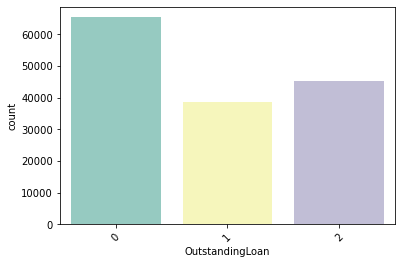

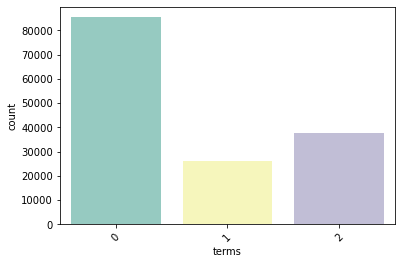

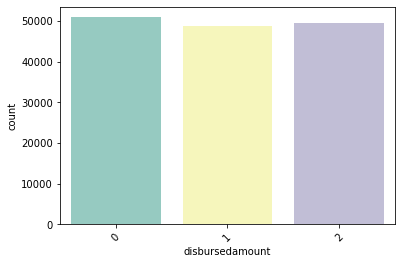

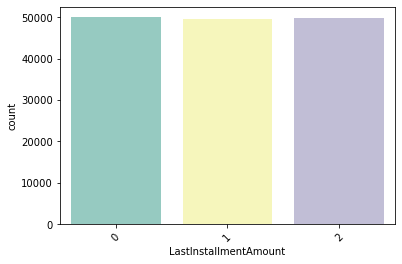

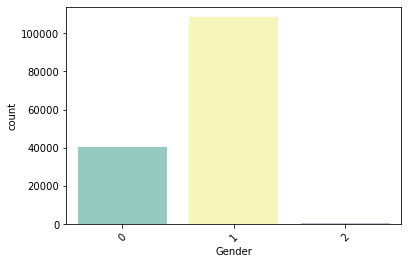

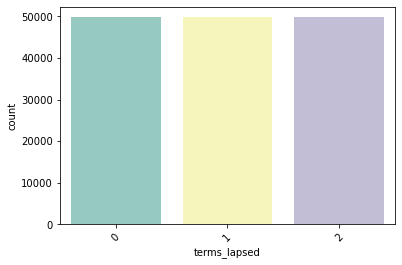

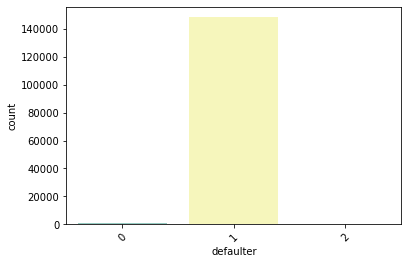

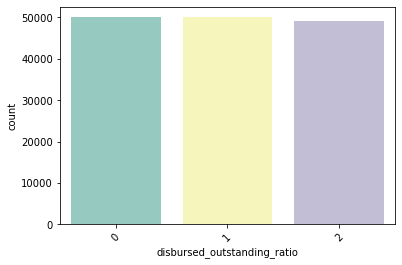

In [15]:
features=['OutstandingLoan', 'terms', 'disbursedamount', 'LastInstallmentAmount','Gender', 
          'terms_lapsed', 'defaulter','disbursed_outstanding_ratio']

for f in features:
    sns.countplot(x=f,data=df,palette="Set3") 
    plt.xticks(rotation=45)
    plt.show()

**Males were the most while unknown gender were the least**

In [16]:
"""features = ['OutstandingLoan','terms','disbursedamount','LastInstallmentAmount','terms_lapsed',
           "disbursed_outstanding_ratio","defaulter"]
for col in features:
    df.boxplot(column=col, by='defaulter', figsize=(6,6))
    plt.title(col)
plt.show()"""
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149321 entries, 0 to 149320
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   OutstandingLoan              149321 non-null  int64         
 1   terms                        149321 non-null  int64         
 2   disbursedamount              149321 non-null  int64         
 3   installmentstartdate         149321 non-null  datetime64[ns]
 4   Lastinstallmentdate          149321 non-null  datetime64[ns]
 5   LastInstallmentAmount        149321 non-null  int64         
 6   disbursementdate             149321 non-null  datetime64[ns]
 7   Gender                       149321 non-null  object        
 8   defaulter                    149321 non-null  object        
 9   terms_lapsed                 149321 non-null  int64         
 10  disbursed_outstanding_ratio  149321 non-null  int64         
dtypes: datetime64[ns](3), int6

In [17]:
"""#this took so long
sns.pairplot(data=df,palette="Set3")"""

'#this took so long\nsns.pairplot(data=df,palette="Set3")'

In [18]:
# The dataset: we drop date columns since they contain no important information for our clustering activity.
# We have actually done some feature engineering from the dates and created a new column; defaulter

#we will drop defaulter = unkonwn and defaulter = no rows as it seems df is for defaulter
#df=df[~((df.defaulter==0)|(df.defaulter==2))]
df.drop(['installmentstartdate','Lastinstallmentdate','disbursementdate'], axis=1,inplace=True)
df.head()

,OutstandingLoan,terms,disbursedamount,LastInstallmentAmount,Gender,defaulter,terms_lapsed,disbursed_outstanding_ratio
0,2,0,0,0,1,1,0,0
1,2,0,0,0,0,1,0,0
2,2,0,0,0,0,1,0,0
3,2,0,0,0,0,1,0,0
4,2,0,0,0,1,1,0,0


# PREDICTION AND CREDIT RATING
## The problem

1. Segmentation of customers with similar credit behaviours
2. identify the common characteristics in each of the clusters
3. Develop a system that can give credit rating for a customer. This rating can be used to judge whether to lend to them and if yes,  the amounts that are ideal for lending to them. This will help the business reduce non-performing loans

In [19]:
for column in df:
    unique_vals=np.unique(df[column])
    len_unique=len(unique_vals)
    if len_unique<10:
        print("The number of values of features : {} is : {} which are -- {}".format(column,len_unique,unique_vals))
        
    else:
        print("The number of values of features : {} is : {}".format(column,len_unique))

The number of values of features : OutstandingLoan is : 3 which are -- [0 1 2]
The number of values of features : terms is : 3 which are -- [0 1 2]
The number of values of features : disbursedamount is : 3 which are -- [0 1 2]
The number of values of features : LastInstallmentAmount is : 3 which are -- [0 1 2]
The number of values of features : Gender is : 3 which are -- [0 1 2]
The number of values of features : defaulter is : 3 which are -- [0 1 2]
The number of values of features : terms_lapsed is : 3 which are -- [0 1 2]
The number of values of features : disbursed_outstanding_ratio is : 3 which are -- [0 1 2]


In [20]:
#predict_df.groupby("defaulter").size()

In [21]:
#Get the train data
X_train=df.values

#running kmeans 
kmeans=KMeans(n_clusters=5,random_state=540)
kmeans=kmeans.fit(X_train)

#print the cluster assigned to each observation
print("The clusters are:",kmeans.labels_)

#print the inertia
print("The inertia is:",kmeans.inertia_)

The clusters are: [4 4 4 ... 0 0 0]
The inertia is: 280760.632793947


In [22]:
# finding best inertia

nclusters=range(2,20)
inertia=[]
for n in nclusters:
    kmeans=KMeans(n_clusters=n,random_state=2)
    kmeans=kmeans.fit(X_train)
    u=kmeans.inertia_
    inertia.append(u)
    print('The inertia for {} is {}'.format(n,u))

The inertia for 2 is 435066.9935203006
The inertia for 3 is 357625.94311398733
The inertia for 4 is 317522.18947382516
The inertia for 5 is 280354.1948962724
The inertia for 6 is 253101.66467658774
The inertia for 7 is 232723.03309276834
The inertia for 8 is 219198.9309080343
The inertia for 9 is 203887.3388284323
The inertia for 10 is 197035.59071036766
The inertia for 11 is 183996.43565360186
The inertia for 12 is 178315.81694432066
The inertia for 13 is 171210.03130563186
The inertia for 14 is 163255.96581045387
The inertia for 15 is 159819.87729463988
The inertia for 16 is 156303.47355456388
The inertia for 17 is 151545.05838556477
The inertia for 18 is 144336.54294503538
The inertia for 19 is 144563.4071789343


Text(0.5, 1.0, 'Inertia Plot Per Cluster')

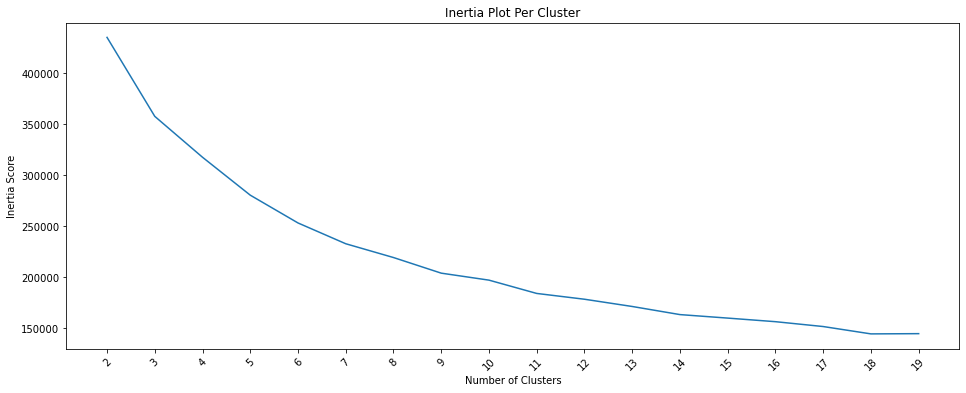

In [23]:
#elbow method for inertia
fig,(ax1)=plt.subplots(1,figsize=(16,6))
xx=np.arange(len(nclusters))
ax1.plot(xx,inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(nclusters,rotation=45)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Score")
plt.title("Inertia Plot Per Cluster")

In [24]:
#Get the train data
X_train=df.values

#running kmeans 
kmeans=KMeans(n_clusters=3,random_state=540)
kmeans=kmeans.fit(X_train)

#prediction for new data
predictions=kmeans.predict(X_train)

#calculating the count of the clusters
unique,counts=np.unique(predictions, return_counts=True)
counts=counts.reshape(1,3)

clcounts_df=pd.DataFrame(counts,columns=["Cluster 1","Cluster 2","Cluster 3"])
clcounts_df

,Cluster 1,Cluster 2,Cluster 3
0,39530,54451,55340


 # PCA

Explained Variation (first two componens): [0.44200519 0.21319806]


<Figure size 432x288 with 0 Axes>

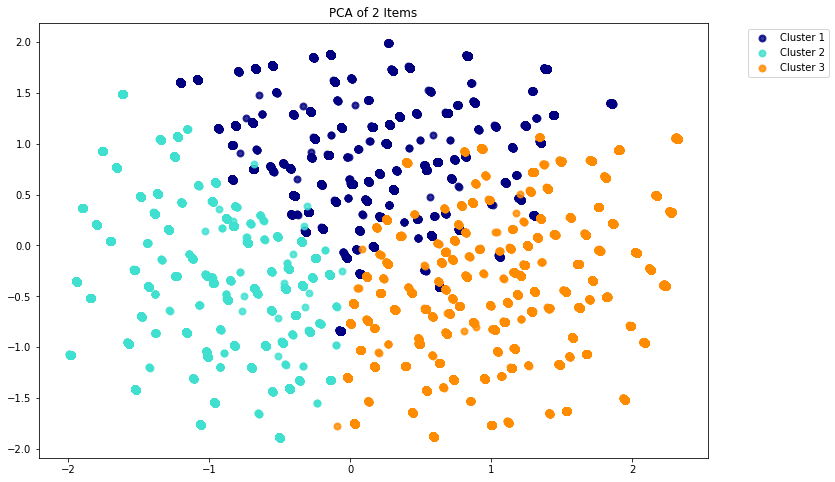

In [25]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = X_train
y_num = predictions

target_names = ["Cluster 1","Cluster 2","Cluster 3"]
pca=PCA(n_components=2, random_state =453)
X_r=pca.fit(X).transform(X)

# % OF VARIANCE explained by each component
print("Explained Variation (first two componens): %s" %str(pca.explained_variance_ratio_))

#plotting the data
plt.figure()
plt.figure(figsize=(12,8))
colors=["navy","turquoise","darkorange","red","black"]
lw=2

for color, i, target_name in zip(colors, [0,1,2],target_names):
    plt.scatter(X_r[y_num==i,0],X_r[y_num == i,1],color=color,alpha=0.8,lw=lw,label=target_name)
    
plt.legend(loc="best",shadow=False,scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.6)
plt.title("PCA of 2 Items")
plt.show()

Total Variance in our dataset is :  4.327577788307964
The 95% variance we weant to have is :  4.111198898892566

Variance Explained With 2 n_components: 2.8354430237176897
Variance Explained With 3 n_components: 3.4392153262570426
Variance Explained With 4 n_components: 3.891037935701698
Variance Explained With 5 n_components: 4.091478849091813
Variance Explained With 6 n_components: 4.235431827065212
Variance Explained With 7 n_components: 4.321708213652514
Variance Explained With 8 n_components: 4.327577788307964


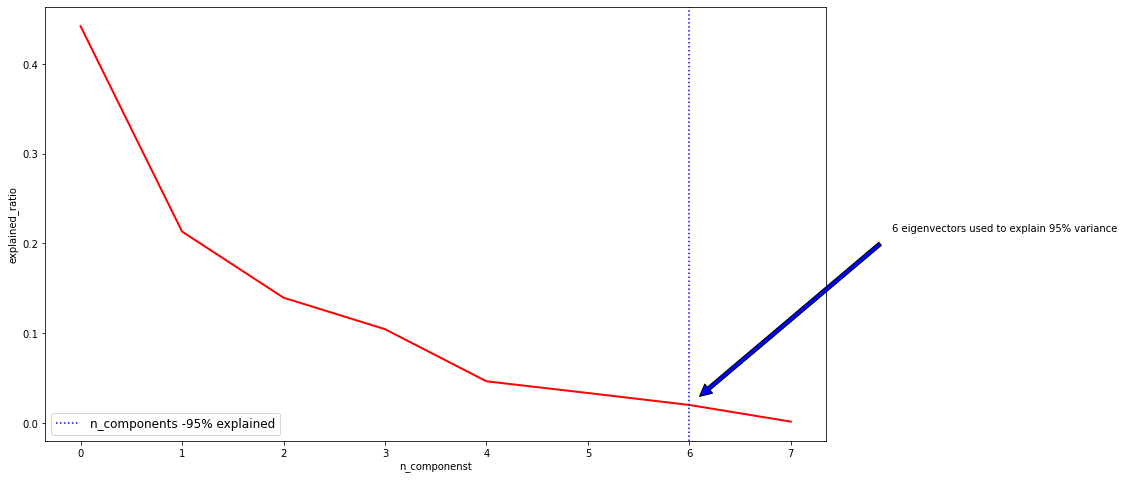

In [26]:
#trying with dimensionality reduction and then kmeans
n_components=X.shape[1]
#running PCA with all components
pca=PCA(n_components=n_components, random_state =453)
X_r=pca.fit(X).transform(X)

#calculatig the 95% variance
total_variance=sum(pca.explained_variance_)
print("Total Variance in our dataset is : ",total_variance)
var_95=total_variance*0.95
print("The 95% variance we weant to have is : ", var_95)
print("")

#creating of a df with the components and explained variance
a=zip(range(0,n_components),pca.explained_variance_)
a=pd.DataFrame(a,columns=["PCA Comp",'Explained Variance'])

#Trying to hit 95%
print("Variance Explained With 2 n_components:", sum(a["Explained Variance"][0:2]))
print("Variance Explained With 3 n_components:", sum(a["Explained Variance"][0:3]))
print("Variance Explained With 4 n_components:", sum(a["Explained Variance"][0:4]))
print("Variance Explained With 5 n_components:", sum(a["Explained Variance"][0:5]))
print("Variance Explained With 6 n_components:", sum(a["Explained Variance"][0:6]))
print("Variance Explained With 7 n_components:", sum(a["Explained Variance"][0:7]))
print("Variance Explained With 8 n_components:", sum(a["Explained Variance"][0:8]))

#plotting the data
plt.figure(1,figsize=(14,8))
plt.plot(pca.explained_variance_ratio_,linewidth=2,c='r')
plt.xlabel('n_componenst')
plt.ylabel('explained_ratio')

#plotiing line with 95%
plt.axvline(6,linestyle=':',label='n_components -95% explained',c='blue')
plt.legend(prop=dict(size=12))

#adding arrow
plt.annotate('6 eigenvectors used to explain 95% variance',xy=(6,pca.explained_variance_ratio_[6]),
                                                               xytext=(8,pca.explained_variance_ratio_[1]),
                                                              arrowprops=dict(facecolor='blue',shrink=0.05))
plt.show()

The inertia for 2 is 435066.9935203006
The inertia for 3 is 357625.94311398733
The inertia for 4 is 317522.18947382516
The inertia for 5 is 280354.1948962724
The inertia for 6 is 253101.66467658774
The inertia for 7 is 232723.03309276834
The inertia for 8 is 219198.9309080343
The inertia for 9 is 203887.33882843226
The inertia for 10 is 197035.59071036766
The inertia for 11 is 183996.43565360186
The inertia for 12 is 178315.81694432066
The inertia for 13 is 171210.03130563186
The inertia for 14 is 163255.96581045387
The inertia for 15 is 159819.87729463994
The inertia for 16 is 156303.47355456388
The inertia for 17 is 151545.05838556477
The inertia for 18 is 144336.54294503538
The inertia for 19 is 144563.4071789343


Text(0.5, 1.0, 'Inertia Plot Per Cluster')

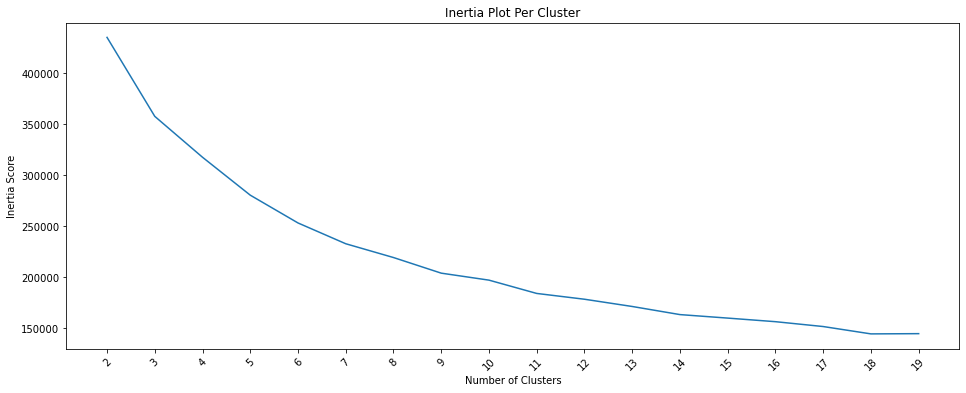

In [27]:
#running PCA with 6 n_components
pca=PCA(n_components=6, random_state =453)
X_r=pca.fit(X).transform(X)


inertia=[]
for n in nclusters:
    kmeans=KMeans(n_clusters=n,random_state=2)
    kmeans=kmeans.fit(X_train)
    u=kmeans.inertia_
    inertia.append(u)
    print('The inertia for {} is {}'.format(n,u))
    
#elbow method for inertia
fig,(ax1)=plt.subplots(1,figsize=(16,6))
xx=np.arange(len(nclusters))
ax1.plot(xx,inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(nclusters,rotation=45)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Score")
plt.title("Inertia Plot Per Cluster")

In [28]:
#running PCA with 6 n_components
pca=PCA(n_components=6, random_state =453)
X_r=pca.fit(X).transform(X)


#running kmeans  with 3 clusters
kmeans=KMeans(n_clusters=3,random_state=540)
kmeans=kmeans.fit(X_train)

clusters=kmeans.labels_

#attach clusters to original dataset
df['clusters']=kmeans.labels_

#create a cluster category
df["cluster_category"]="No Data"
df.loc[df.clusters==0,'cluster_category']='cluster 1'
df.loc[df.clusters==1,'cluster_category']='cluster 2'
df.loc[df.clusters==2,'cluster_category']='cluster 3'
df.head()

,OutstandingLoan,terms,disbursedamount,LastInstallmentAmount,Gender,defaulter,terms_lapsed,disbursed_outstanding_ratio,clusters,cluster_category
0,2,0,0,0,1,1,0,0,1,cluster 2
1,2,0,0,0,0,1,0,0,1,cluster 2
2,2,0,0,0,0,1,0,0,1,cluster 2
3,2,0,0,0,0,1,0,0,1,cluster 2
4,2,0,0,0,1,1,0,0,1,cluster 2


In [29]:
df.columns

Index(['OutstandingLoan', 'terms', 'disbursedamount', 'LastInstallmentAmount',
       'Gender', 'defaulter', 'terms_lapsed', 'disbursed_outstanding_ratio',
       'clusters', 'cluster_category'],
      dtype='object')

In [30]:
df['OutstandingLoan'].loc[df['OutstandingLoan']==1]="Betwn 0 & 48,000"
df['OutstandingLoan'].loc[df['OutstandingLoan']==0]="Betwn 49,000 & 60,000"
df['OutstandingLoan'].loc[df['OutstandingLoan']==2]="Above 60,000"

df['terms'].loc[df['terms']==0]="Betwn 0 & 3"
df['terms'].loc[df['terms']==2]="Betwn 3 & 12"
df['terms'].loc[df['terms']==1]="Above 12"

df['disbursedamount'].loc[df['disbursedamount']==0]="Betwn 0 & 9,000"
df['disbursedamount'].loc[df['disbursedamount']==1]="Betwn 9,000 & 40,000"
df['disbursedamount'].loc[df['disbursedamount']==2]="Above 40,000"

df['LastInstallmentAmount'].loc[df['LastInstallmentAmount']==0]="Betwn 0 & 2,500"
df['LastInstallmentAmount'].loc[df['LastInstallmentAmount']==1]="Betwn 2,500 & 5800"
df['LastInstallmentAmount'].loc[df['LastInstallmentAmount']==2]="Above 5,800"

df['disbursed_outstanding_ratio'].loc[df['disbursed_outstanding_ratio']==0]="Betwn 0 & 0.2"
df['disbursed_outstanding_ratio'].loc[df['disbursed_outstanding_ratio']==1]="Betwn 0.2 & 1"
df['disbursed_outstanding_ratio'].loc[df['disbursed_outstanding_ratio']==2]="Above 1"

df['terms_lapsed'].loc[df['terms_lapsed']==0]="Betwn 0 & 70"
df['terms_lapsed'].loc[df['terms_lapsed']==1]="Betwn 70 & 121"
df['terms_lapsed'].loc[df['terms_lapsed']==2]="Above 121"

df['Gender'].loc[df['Gender']==0]="Female"
df['Gender'].loc[df['Gender']==1]="Male"
df['Gender'].loc[df['Gender']==2]="Undisclosed"

df['defaulter'].loc[df['defaulter']==0]="No"
df['defaulter'].loc[df['defaulter']==1]="Yes"
df['defaulter'].loc[df['defaulter']==2]="Unknown"

C:\Users\julmn\AppData\Local\Temp\ipykernel_11268\3796329904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OutstandingLoan'].loc[df['OutstandingLoan']==1]="Betwn 0 & 48,000"
C:\Users\julmn\AppData\Local\Temp\ipykernel_11268\3796329904.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['terms'].loc[df['terms']==0]="Betwn 0 & 3"
C:\Users\julmn\AppData\Local\Temp\ipykernel_11268\3796329904.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [31]:
df.head()

,OutstandingLoan,terms,disbursedamount,LastInstallmentAmount,Gender,defaulter,terms_lapsed,disbursed_outstanding_ratio,clusters,cluster_category
0,"Above 60,000",Betwn 0 & 3,"Betwn 0 & 9,000","Betwn 0 & 2,500",Male,Yes,Betwn 0 & 70,Betwn 0 & 0.2,1,cluster 2
1,"Above 60,000",Betwn 0 & 3,"Betwn 0 & 9,000","Betwn 0 & 2,500",Female,Yes,Betwn 0 & 70,Betwn 0 & 0.2,1,cluster 2
2,"Above 60,000",Betwn 0 & 3,"Betwn 0 & 9,000","Betwn 0 & 2,500",Female,Yes,Betwn 0 & 70,Betwn 0 & 0.2,1,cluster 2
3,"Above 60,000",Betwn 0 & 3,"Betwn 0 & 9,000","Betwn 0 & 2,500",Female,Yes,Betwn 0 & 70,Betwn 0 & 0.2,1,cluster 2
4,"Above 60,000",Betwn 0 & 3,"Betwn 0 & 9,000","Betwn 0 & 2,500",Male,Yes,Betwn 0 & 70,Betwn 0 & 0.2,1,cluster 2


In [32]:
df_=pd.concat([df,df_cols],axis=1)

In [33]:
df_.head()

,OutstandingLoan,terms,disbursedamount,LastInstallmentAmount,Gender,defaulter,terms_lapsed,disbursed_outstanding_ratio,clusters,cluster_category,OutstandingLoan,installmentstartdate,Lastinstallmentdate,disbursementdate
0,"Above 60,000",Betwn 0 & 3,"Betwn 0 & 9,000","Betwn 0 & 2,500",Male,Yes,Betwn 0 & 70,Betwn 0 & 0.2,1,cluster 2,-18134.96,2022-02-18,2022-02-18,2022-01-19
1,"Above 60,000",Betwn 0 & 3,"Betwn 0 & 9,000","Betwn 0 & 2,500",Female,Yes,Betwn 0 & 70,Betwn 0 & 0.2,1,cluster 2,-6769.98,2021-12-31,2021-12-31,2021-12-01
2,"Above 60,000",Betwn 0 & 3,"Betwn 0 & 9,000","Betwn 0 & 2,500",Female,Yes,Betwn 0 & 70,Betwn 0 & 0.2,1,cluster 2,-10000.00,2021-12-30,2021-12-30,2021-11-30
3,"Above 60,000",Betwn 0 & 3,"Betwn 0 & 9,000","Betwn 0 & 2,500",Female,Yes,Betwn 0 & 70,Betwn 0 & 0.2,1,cluster 2,-30000.00,2021-12-26,2021-12-26,2021-11-26
4,"Above 60,000",Betwn 0 & 3,"Betwn 0 & 9,000","Betwn 0 & 2,500",Male,Yes,Betwn 0 & 70,Betwn 0 & 0.2,1,cluster 2,-1269.98,2021-12-26,2021-12-26,2021-11-26


In [34]:
df_.to_csv("cleaned_data.csv")